# 01. Import Libaray

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from itertools import cycle
import seaborn as sn
%matplotlib inline

In [2]:
import tensorflow as tf

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier

# 02. Define Function

## Classification Report & Confusion Matrix

In [39]:
def evaluation(model, X, y, label_map={0: "Angry", 1: "Happy", 2: "Sad", 3: "Neutral"}):
    y_pred = model.predict(X)
    
    print('\nClassification Report')
    print(classification_report(y_pred, y, target_names=['Angry','Happy','Sad','Neutral']))

    cm = confusion_matrix(y, y_pred, normalize='true')
    cm2 = confusion_matrix(y, y_pred)

    label_index = list(label_map.keys())
    label_name = list(label_map.values())
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap='Blues')
    for i in label_index:
        for j in label_index:
            plt.text(
                i, j, '{}\n({}%)'.format(cm2[j][i], round(cm[j][i] * 100, 1)) ,
                horizontalalignment="center",
                verticalalignment="center",
                color='black' if cm[j][i] < 0.5 else 'white'
                
            )
    plt.xticks(label_index, label_name)
    plt.yticks(label_index, label_name)
    plt.xlabel('y')
    plt.ylabel('y_pred', rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

In [40]:
# LGBM 모델은 model.predict(X)를 했을 때 predicted Y가 아닌 확률들을 출력하기 떄문에 argmax 과정을 한 번 추가로 거쳤습니다.

def evaluation_lgb(model, X, y, label_map={0: "Angry", 1: "Happy", 2: "Sad", 3: "Neutral"}):
    y_pred_prob = model.predict(X)
    y_pred = [np.argmax(line) for line in y_pred_prob]
    
    print('\nClassification Report')
    print(classification_report(y_pred, y, target_names=['Angry','Happy','Sad','Neutral']))

    cm = confusion_matrix(y, y_pred, normalize='true')
    cm2 = confusion_matrix(y, y_pred)

    label_index = list(label_map.keys())
    label_name = list(label_map.values())
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap='Blues')
    for i in label_index:
        for j in label_index:
            plt.text(
                i, j, '{}\n({}%)'.format(cm2[j][i], round(cm[j][i] * 100, 1)) ,
                horizontalalignment="center",
                verticalalignment="center",
                color='black' if cm[j][i] < 0.5 else 'white'
                
            )
    plt.xticks(label_index, label_name)
    plt.yticks(label_index, label_name)
    plt.xlabel('y')
    plt.ylabel('y_pred', rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

## ROC curve

In [42]:
def plot_roc_curve(y_test_binary, y_pred_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=2,
    )

    lw=2

    # colors = cycle(["crimson", "olivedrab", "lightseagreen", "orchid"])
    colors = cycle(list(mcolors.BASE_COLORS.keys()))
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve before Resampling")
    plt.legend(loc="lower right")
    plt.show()

In [51]:
def plot_roc_curve(y_test_binary, y_pred_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=2,
    )

    lw=2

    # colors = cycle(["crimson", "olivedrab", "lightseagreen", "orchid"])
    colors = cycle(list(mcolors.BASE_COLORS.keys()))
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve before Resampling")
    plt.legend(loc="lower right")
    plt.show()

# 03. Load Dataset

In [81]:
dataset_csv = pd.read_csv("./Face_Emotion_Detection.csv", sep=",", header=0, index_col=None)

In [82]:
#Convert Pandas to Numpy
dataset = np.zeros((dataset_csv.shape[0], dataset_csv.shape[1])) 

for i in range(dataset_csv.shape[0]):
    dataset[i] = dataset_csv.iloc[i, 0:]

print(dataset.shape)
np.random.seed(0)
np.random.shuffle(dataset)

data_value = np.zeros((dataset.shape[0], dataset.shape[1]-1)) 
data_label = np.zeros((dataset.shape[0], 1)) # Enpty array
print(data_value.shape)
print(data_label.shape)

for i in range(dataset.shape[0]):
    data_value[i]= dataset[i][1::] # Pixel value  
    data_label[i]= dataset[i][0] # Data label

data_image = data_value.reshape((data_value.shape[0], 36, 36)) 

X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, 
                                                    test_size=0.2, random_state=111, 
                                                    stratify=data_label)

(9464, 1297)
(9464, 1296)
(9464, 1)


In [17]:
X_train /= 255.0
X_test /= 255.0

In [18]:
y_train, y_test = y_train.ravel(), y_test.ravel()
X_train, X_test = X_train.reshape(7571,36*36), X_test.reshape(1893,36*36)

In [37]:
# roc curve 그리기 위한 이진화
from sklearn.preprocessing import label_binarize

y_test_binary = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_test_binary.shape[1]

y_test_binary_st = label_binarize(y_test_st, classes=[0,1,2,3])
n_classes_st = y_test_binary_st.shape[1]

## SMOTE + TOMEKLINK Dataset

In [19]:
X_test_sm_tom = np.load('smote_tomek_test_x.npy')
X_train_sm_tom = np.load('smote_tomek_train_x.npy')
y_test_st= np.load('smote_tomek_test_y.npy')
y_train_st= np.load('smote_tomek_train_y.npy')

In [20]:
X_train_st = X_train_sm_tom.reshape(-1,36*36)
X_test_st = X_test_sm_tom.reshape(-1,36*36)

# 04. Sampling Process

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=111)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [22]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=111)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

# 05. Generate Model & Train Model & Evaluate

## XGBoost

In [24]:
xgb=XGBClassifier(booster='gbtree',objective='multi:softprob', 
                  n_estimators=500, random_state=111, use_label_encoder=False)

xgb.fit(X_train, y_train, eval_metric='merror', eval_set=[(X_test, y_test)],
        early_stopping_rounds=100, verbose=10)

[0]	validation_0-merror:0.47596
[10]	validation_0-merror:0.40570
[20]	validation_0-merror:0.38774
[30]	validation_0-merror:0.38299
[40]	validation_0-merror:0.37190
[50]	validation_0-merror:0.36820
[60]	validation_0-merror:0.36767
[70]	validation_0-merror:0.36556
[80]	validation_0-merror:0.36820
[90]	validation_0-merror:0.36450
[100]	validation_0-merror:0.36292
[110]	validation_0-merror:0.35922
[120]	validation_0-merror:0.35552
[130]	validation_0-merror:0.35552
[140]	validation_0-merror:0.34918
[150]	validation_0-merror:0.34918
[160]	validation_0-merror:0.35077
[170]	validation_0-merror:0.34813
[180]	validation_0-merror:0.34548
[190]	validation_0-merror:0.34760
[200]	validation_0-merror:0.34601
[210]	validation_0-merror:0.34337
[220]	validation_0-merror:0.34443
[230]	validation_0-merror:0.34126
[240]	validation_0-merror:0.34443
[250]	validation_0-merror:0.34284
[260]	validation_0-merror:0.34284
[270]	validation_0-merror:0.34126
[280]	validation_0-merror:0.34179
[290]	validation_0-merror

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [30]:
y_pred = xgb.predict(X_test)

xgb.score(X_test, y_test)

0.6619123085050185


Classification Report
              precision    recall  f1-score   support

       Angry       0.31      0.55      0.40       163
       Happy       0.90      0.76      0.82       974
         Sad       0.23      0.52      0.32       124
     Neutral       0.72      0.57      0.64       632

    accuracy                           0.66      1893
   macro avg       0.54      0.60      0.54      1893
weighted avg       0.74      0.66      0.69      1893



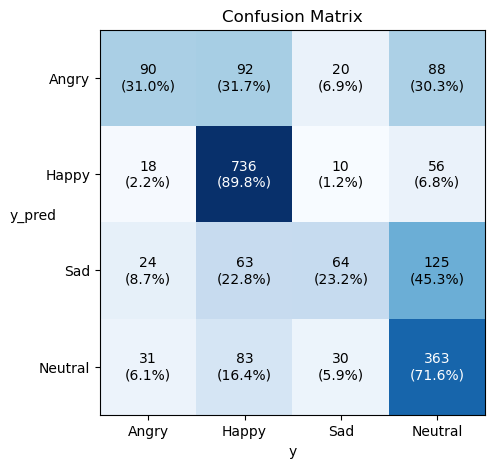

In [31]:
evaluation(xgb, X_test, y_test)

In [32]:
y_pred_proba = xgb.predict_proba(X_test)

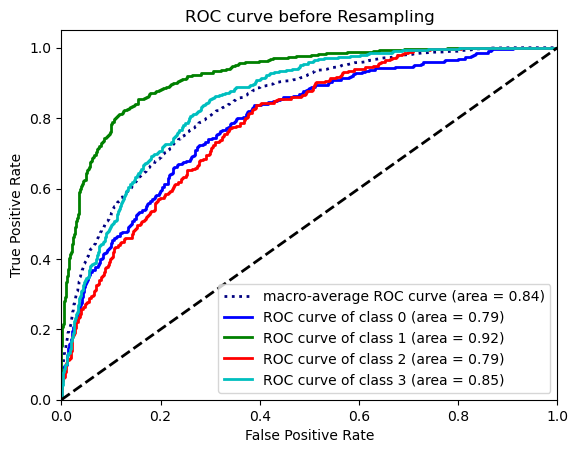

In [35]:
plot_roc_curve(y_test_binary, y_pred_proba)

## XGBoost + SMOTE

In [48]:
xgb_sm=XGBClassifier(booster='gbtree',objective='multi:softprob', 
                  n_estimators=500, random_state=111, use_label_encoder=False)

xgb_sm.fit(X_train_sm, y_train_sm, eval_metric='merror', eval_set=[(X_test, y_test)],
        early_stopping_rounds=100, verbose=10)

xgb_sm.score(X_test, y_test)

[0]	validation_0-merror:0.56471
[10]	validation_0-merror:0.43370
[20]	validation_0-merror:0.40623
[30]	validation_0-merror:0.38986
[40]	validation_0-merror:0.38563
[50]	validation_0-merror:0.37982
[60]	validation_0-merror:0.37771
[70]	validation_0-merror:0.37771
[80]	validation_0-merror:0.37031
[90]	validation_0-merror:0.36978
[100]	validation_0-merror:0.37084
[110]	validation_0-merror:0.37084
[120]	validation_0-merror:0.36978
[130]	validation_0-merror:0.36609
[140]	validation_0-merror:0.36239
[150]	validation_0-merror:0.36028
[160]	validation_0-merror:0.36080
[170]	validation_0-merror:0.35922
[180]	validation_0-merror:0.35763
[190]	validation_0-merror:0.35922
[200]	validation_0-merror:0.35288
[210]	validation_0-merror:0.35499
[220]	validation_0-merror:0.35341
[230]	validation_0-merror:0.35446
[240]	validation_0-merror:0.34918
[250]	validation_0-merror:0.35182
[260]	validation_0-merror:0.35394
[270]	validation_0-merror:0.34918
[280]	validation_0-merror:0.34865
[290]	validation_0-merror

0.6550449022715267


Classification Report
              precision    recall  f1-score   support

       Angry       0.33      0.48      0.39       202
       Happy       0.88      0.78      0.83       919
         Sad       0.30      0.45      0.36       186
     Neutral       0.67      0.58      0.62       586

    accuracy                           0.66      1893
   macro avg       0.55      0.57      0.55      1893
weighted avg       0.70      0.66      0.67      1893



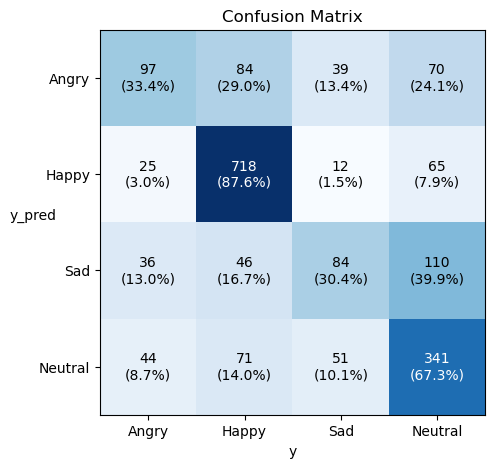

In [52]:
evaluation(xgb_sm, X_test, y_test)

In [53]:
y_prob_sm = xgb_sm.predict_proba(X_test)

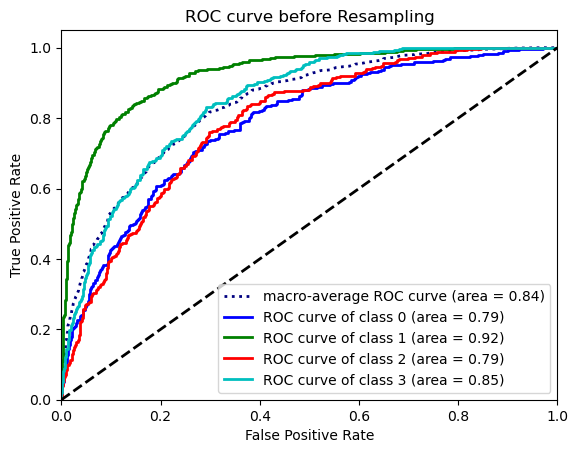

In [54]:
plot_roc_curve(y_test_binary, y_prob_sm)

## XGBoost + ADASYN

In [55]:
xgb_ada=XGBClassifier(booster='gbtree',objective='multi:softprob', 
                  n_estimators=500, random_state=111, use_label_encoder=False)

xgb_ada.fit(X_train_ada, y_train_ada, eval_metric='merror', eval_set=[(X_test, y_test)],
        early_stopping_rounds=100, verbose=10)

xgb_ada.score(X_test, y_test)

[0]	validation_0-merror:0.55890
[10]	validation_0-merror:0.42789
[20]	validation_0-merror:0.41046
[30]	validation_0-merror:0.40201
[40]	validation_0-merror:0.40518
[50]	validation_0-merror:0.38986
[60]	validation_0-merror:0.37771
[70]	validation_0-merror:0.37190
[80]	validation_0-merror:0.36714
[90]	validation_0-merror:0.36239
[100]	validation_0-merror:0.36397
[110]	validation_0-merror:0.36028
[120]	validation_0-merror:0.35922
[130]	validation_0-merror:0.35975
[140]	validation_0-merror:0.35711
[150]	validation_0-merror:0.35975
[160]	validation_0-merror:0.35816
[170]	validation_0-merror:0.35446
[180]	validation_0-merror:0.35182
[190]	validation_0-merror:0.35288
[200]	validation_0-merror:0.34865
[210]	validation_0-merror:0.35129
[220]	validation_0-merror:0.35129
[230]	validation_0-merror:0.34918
[240]	validation_0-merror:0.35024
[250]	validation_0-merror:0.35394
[260]	validation_0-merror:0.35129
[270]	validation_0-merror:0.35024
[280]	validation_0-merror:0.35077
[290]	validation_0-merror

0.659270998415214


Classification Report
              precision    recall  f1-score   support

       Angry       0.34      0.47      0.40       211
       Happy       0.89      0.79      0.83       924
         Sad       0.30      0.45      0.36       185
     Neutral       0.67      0.59      0.63       573

    accuracy                           0.66      1893
   macro avg       0.55      0.57      0.55      1893
weighted avg       0.70      0.66      0.68      1893



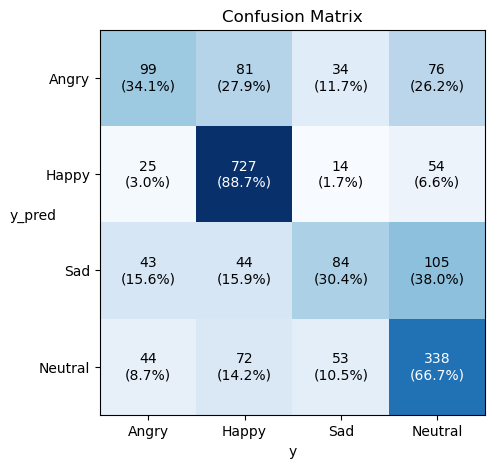

In [56]:
evaluation(xgb_ada, X_test, y_test)

In [57]:
y_prob_ada = xgb_ada.predict_proba(X_test)

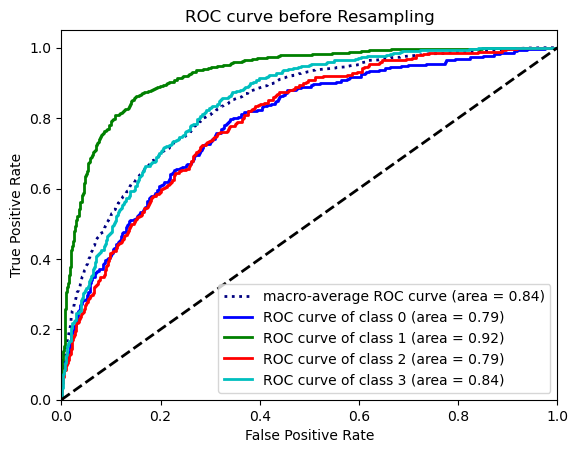

In [58]:
plot_roc_curve(y_test_binary, y_prob_ada)

## XGBoost + SMOTE + TOMEKLINK

In [59]:
xgb_st=XGBClassifier(booster='gbtree',objective='multi:softprob', 
                  n_estimators=500, random_state=111, use_label_encoder=False)

xgb_st.fit(X_train_st, y_train_st, eval_metric='merror', eval_set=[(X_test_st, y_test_st)],
        early_stopping_rounds=100, verbose=10)

xgb_st.score(X_test_st, y_test_st)

[0]	validation_0-merror:0.54675
[10]	validation_0-merror:0.42050
[20]	validation_0-merror:0.39620
[30]	validation_0-merror:0.39303
[40]	validation_0-merror:0.39091
[50]	validation_0-merror:0.38035
[60]	validation_0-merror:0.37824
[70]	validation_0-merror:0.37612
[80]	validation_0-merror:0.37665
[90]	validation_0-merror:0.37190
[100]	validation_0-merror:0.37031
[110]	validation_0-merror:0.36556
[120]	validation_0-merror:0.36450
[130]	validation_0-merror:0.36661
[140]	validation_0-merror:0.36186
[150]	validation_0-merror:0.36609
[160]	validation_0-merror:0.36397
[170]	validation_0-merror:0.36292
[180]	validation_0-merror:0.35869
[190]	validation_0-merror:0.35922
[200]	validation_0-merror:0.35975
[210]	validation_0-merror:0.35552
[220]	validation_0-merror:0.35816
[230]	validation_0-merror:0.35711
[240]	validation_0-merror:0.35711
[250]	validation_0-merror:0.35711
[260]	validation_0-merror:0.35658
[270]	validation_0-merror:0.35763
[280]	validation_0-merror:0.35605
[290]	validation_0-merror

0.6465927099841522


Classification Report
              precision    recall  f1-score   support

       Angry       0.35      0.49      0.41       206
       Happy       0.87      0.78      0.82       921
         Sad       0.25      0.41      0.31       164
     Neutral       0.67      0.56      0.61       602

    accuracy                           0.65      1893
   macro avg       0.53      0.56      0.54      1893
weighted avg       0.70      0.65      0.67      1893



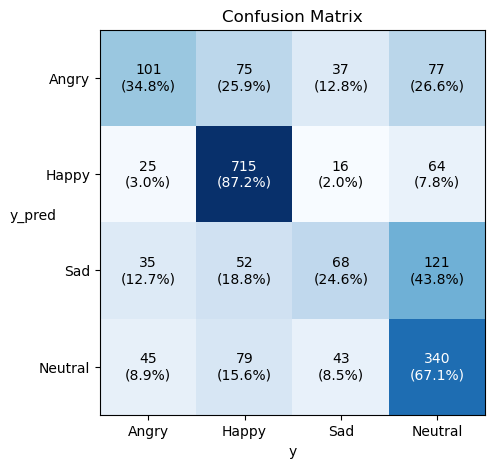

In [60]:
evaluation(xgb_st, X_test_st, y_test_st)

In [61]:
y_prob_st = xgb_st.predict_proba(X_test_st)

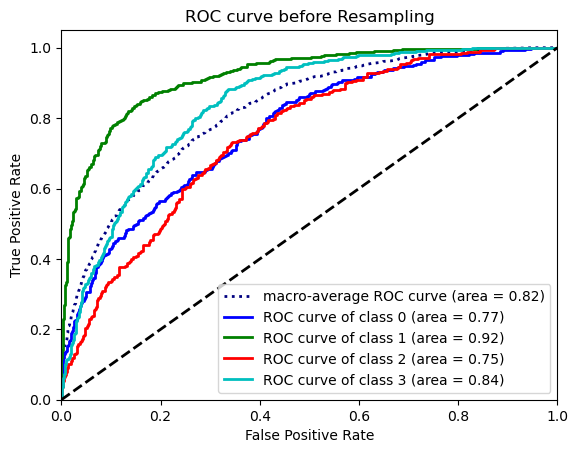

In [62]:
plot_roc_curve(y_test_binary_st, y_prob_st)

## LightGBM

In [66]:
# LGBM dataset 형태로 변환

train_data = lgb.Dataset(X_train, label=y_train)
test_data= lgb.Dataset(X_test, label=y_test)

In [67]:
param = {'objective':'multiclass', 'metric':'multi_error', 
         'num_class':4}
lgb_model = lgb.train(param, train_data, 1000, test_data, 
                      verbose_eval=100)

y_prob = lgb_model.predict(X_test)
y_pred = [np.argmax(line) for line in y_prob]

accuracy_score(y_test, y_pred)

/Users/kunwooshin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305980
[LightGBM] [Info] Number of data points in the train set: 7571, number of used features: 1296
[LightGBM] [Info] Start training from score -1.875905
[LightGBM] [Info] Start training from score -0.836482
[LightGBM] [Info] Start training from score -1.926291
[LightGBM] [Info] Start training from score -1.317275
[100]	valid_0's multi_error: 0.360275
[200]	valid_0's multi_error: 0.35869
[300]	valid_0's multi_error: 0.353407
[400]	valid_0's multi_error: 0.347596
[500]	valid_0's multi_error: 0.34654
[600]	valid_0's multi_error: 0.345483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.6603275224511358


Classification Report
              precision    recall  f1-score   support

       Angry       0.30      0.54      0.38       160
       Happy       0.90      0.75      0.82       993
         Sad       0.23      0.56      0.32       112
     Neutral       0.71      0.57      0.63       628

    accuracy                           0.66      1893
   macro avg       0.53      0.60      0.54      1893
weighted avg       0.75      0.66      0.69      1893



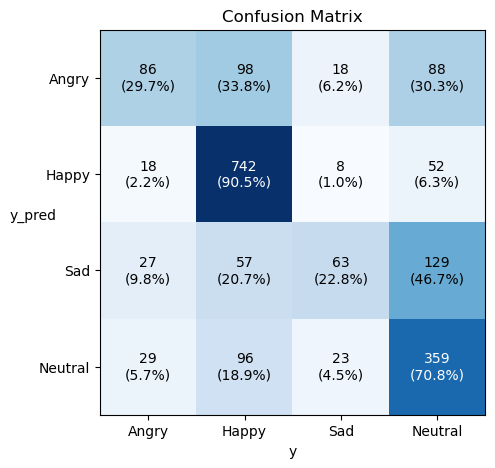

In [68]:
evaluation_lgb(lgb_model, X_test, y_test)

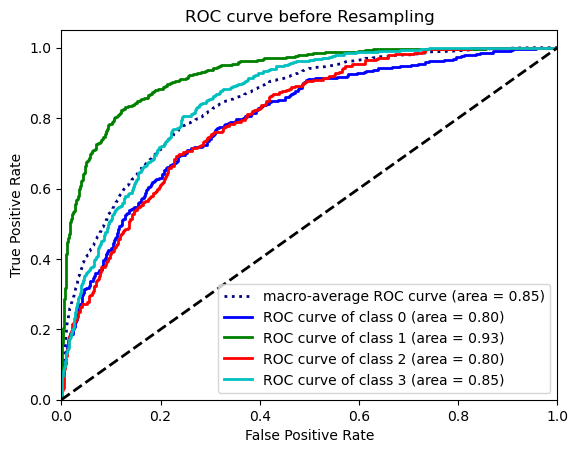

In [69]:
plot_roc_curve(y_test_binary, y_prob)

## LGBM + SMOTE

In [70]:
train_data_sm = lgb.Dataset(X_train_sm, label=y_train_sm)
test_data= lgb.Dataset(X_test, label=y_test)

lgb_sm = lgb.train(param, train_data_sm, 1000, test_data, 
                      verbose_eval=100)

y_prob_sm = lgb_sm.predict(X_test)
y_pred_sm = [np.argmax(line) for line in y_prob_sm]

accuracy_score(y_test, y_pred_sm)

/Users/kunwooshin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326617
[LightGBM] [Info] Number of data points in the train set: 13120, number of used features: 1296
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[100]	valid_0's multi_error: 0.381405
[200]	valid_0's multi_error: 0.352879
[300]	valid_0's multi_error: 0.352351
[400]	valid_0's multi_error: 0.351294
[500]	valid_0's multi_error: 0.347068
[600]	valid_0's multi_error: 0.350238
[700]	valid_0's multi_error: 0.347068
[800]	valid_0's multi_error: 0.341786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.6555731642894875


Classification Report
              precision    recall  f1-score   support

       Angry       0.35      0.48      0.40       214
       Happy       0.88      0.78      0.83       932
         Sad       0.28      0.46      0.35       169
     Neutral       0.67      0.58      0.62       578

    accuracy                           0.66      1893
   macro avg       0.55      0.57      0.55      1893
weighted avg       0.70      0.66      0.67      1893



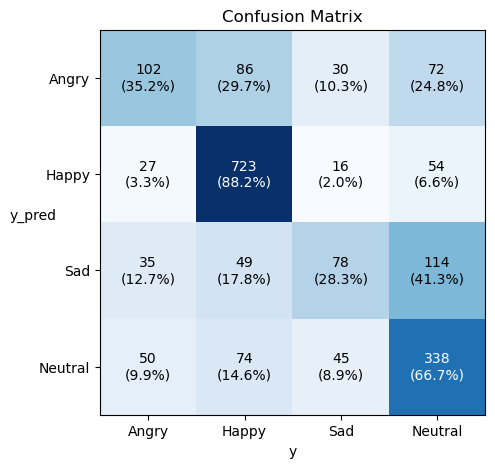

In [71]:
evaluation_lgb(lgb_sm, X_test, y_test)

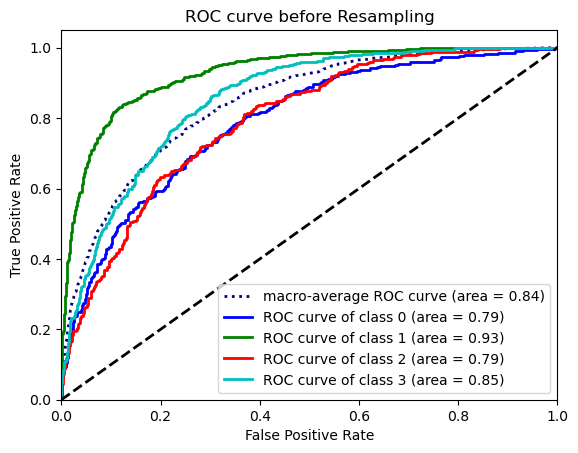

In [72]:
plot_roc_curve(y_test_binary, y_prob_sm)

## LGBM + ADASYN

In [73]:
train_data_ada = lgb.Dataset(X_train_ada, label=y_train_ada)
test_data= lgb.Dataset(X_test, label=y_test)

lgb_ada = lgb.train(param, train_data_ada, 1000, test_data, 
                      verbose_eval=100)

y_prob_ada = lgb_ada.predict(X_test)
y_pred_ada = [np.argmax(line) for line in y_prob_ada]

accuracy_score(y_test, y_pred_ada)

/Users/kunwooshin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326541
[LightGBM] [Info] Number of data points in the train set: 12686, number of used features: 1296
[LightGBM] [Info] Start training from score -1.395958
[LightGBM] [Info] Start training from score -1.352656
[LightGBM] [Info] Start training from score -1.435242
[LightGBM] [Info] Start training from score -1.363384
[100]	valid_0's multi_error: 0.366086
[200]	valid_0's multi_error: 0.341786
[300]	valid_0's multi_error: 0.340201
[400]	valid_0's multi_error: 0.338088
[500]	valid_0's multi_error: 0.330164
[600]	valid_0's multi_error: 0.330692
[700]	valid_0's multi_error: 0.328579
[800]	valid_0's multi_error: 0.329635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.6724775488642366


Classification Report
              precision    recall  f1-score   support

       Angry       0.36      0.53      0.42       195
       Happy       0.91      0.78      0.84       953
         Sad       0.31      0.49      0.38       175
     Neutral       0.67      0.60      0.64       570

    accuracy                           0.67      1893
   macro avg       0.56      0.60      0.57      1893
weighted avg       0.72      0.67      0.69      1893



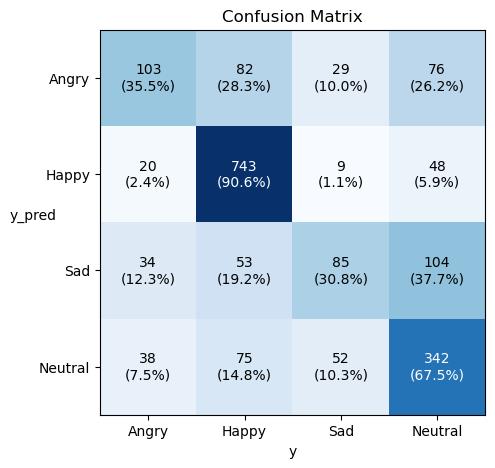

In [74]:
evaluation_lgb(lgb_ada, X_test, y_test)

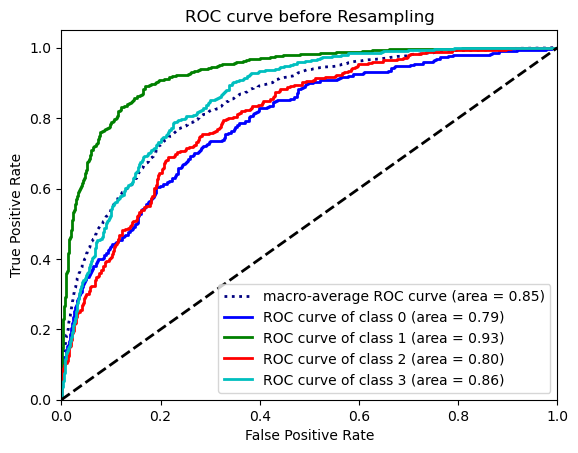

In [75]:
plot_roc_curve(y_test_binary, y_prob_ada)

## LGBM + SMOTE + TOMETLINK

In [76]:
train_data_st = lgb.Dataset(X_train_st, label=y_train_st)
test_data_st= lgb.Dataset(X_test_st, label=y_test_st)

lgb_st = lgb.train(param, train_data_st, 1000, test_data_st, 
                      verbose_eval=100)

y_prob_st = lgb_st.predict(X_test_st)
y_pred_st = [np.argmax(line) for line in y_prob_st]

accuracy_score(y_test_st, y_pred_st)

/Users/kunwooshin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305633
[LightGBM] [Info] Number of data points in the train set: 10294, number of used features: 1296
[LightGBM] [Info] Start training from score -1.536760
[LightGBM] [Info] Start training from score -1.150755
[LightGBM] [Info] Start training from score -1.547203
[LightGBM] [Info] Start training from score -1.363817
[100]	valid_0's multi_error: 0.375594
[200]	valid_0's multi_error: 0.366614
[300]	valid_0's multi_error: 0.35552
[400]	valid_0's multi_error: 0.350766
[500]	valid_0's multi_error: 0.344955
[600]	valid_0's multi_error: 0.346012
[700]	valid_0's multi_error: 0.350238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's multi_error: 0.350766


0.6492340200739567


Classification Report
              precision    recall  f1-score   support

       Angry       0.34      0.52      0.41       189
       Happy       0.88      0.77      0.82       939
         Sad       0.22      0.37      0.27       162
     Neutral       0.69      0.58      0.63       603

    accuracy                           0.65      1893
   macro avg       0.53      0.56      0.53      1893
weighted avg       0.71      0.65      0.67      1893



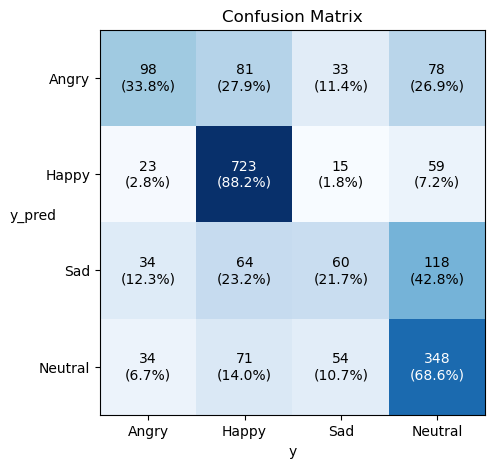

In [77]:
evaluation_lgb(lgb_st, X_test_st, y_test_st)

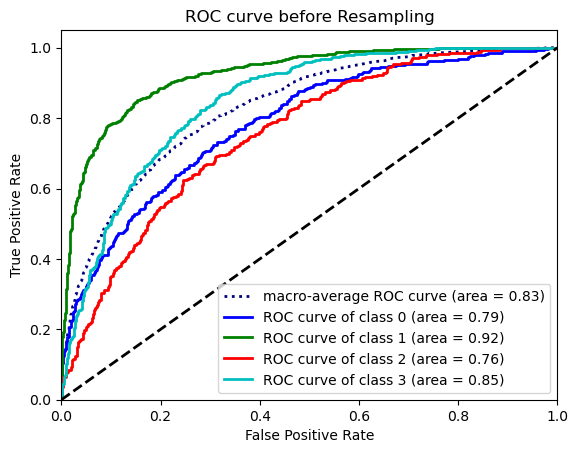

In [78]:
plot_roc_curve(y_test_binary_st, y_prob_st)